# [T04] Laporan Proyek: Analisis Frekuensi dan Rekonstruksi Sinyal Musik

- Nama: Rizky Cahyono Putra
- NIM: 442023611012

## Pendahuluan
Laporan ini menyajikan hasil eksplorasi transformasi sinyal dari domain waktu ke domain frekuensi menggunakan Fast Fourier Transform (FFT). Studi kasus yang digunakan adalah sinyal suara bicara, sesuai dengan instruksi tugas. Tujuannya adalah untuk memahami bagaimana sebuah sinyal suara dapat direpresentasikan dalam domain frekuensi dan bagaimana kita dapat mengekstrak informasi penting—seperti nada dasar (pitch)—dari representasi tersebut.

Proses yang dilakukan meliputi pemuatan sinyal suara dari file lokal, penerapan FFT, identifikasi frekuensi dominan, dan visualisasi hasil untuk analisis.

## Setup Library

Penjelasan Konseptual: Langkah pertama adalah menyiapkan lingkungan kerja dengan mengimpor semua library yang diperlukan. Kita akan menggunakan NumPy untuk komputasi numerik, Matplotlib untuk visualisasi, SciPy untuk membaca file audio (.wav) dan menemukan puncak pada spektrum, serta IPython.display untuk memutar audio langsung di dalam notebook.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from IPython.display import display, Audio

plt.style.use('seaborn-v0_8-whitegrid')
print(" Library berhasil diimpor dan siap digunakan.")

 Library berhasil diimpor dan siap digunakan.


## Memuat sinyal
Penjelasan Konseptual: Kita akan memuat sinyal suara dari file .wav yang ada di komputer. Fungsi wavfile.read dari SciPy akan membaca file tersebut dan mengembalikannya sebagai dua variabel: sample_rate (frekuensi sampling) dan audio_data (array numerik yang merepresentasikan amplitudo sinyal).

In [16]:
PATH = '/kaggle/input/sound-girl-saying-hello-and-mouse-click/783969__luamoon__girl-saying-hello-happy.wav'

try:
    # baca file
    sample_rate, audio_data = wavfile.read(PATH)

    #mengambil satu channel jika audio stero
    if audio_data.ndim > 1:
        audio_data = audio_data[:, 0]

    #nnormalisasi sinyal rentang [-1.0, 1.0]
    audio_signal = audio_data.astype(np.float32) / np.max(np.abs(audio_data))

    # sumbu waktu
    N = len(audio_signal)
    duration = N / sample_rate
    t = np.linspace(0., duration, N, endpoint=False)

    print(f"File audio '{PATH}' berhasil dimuat.")
    print(f"Sample Rate: {sample_rate} Hz")
    print(f"Durasi: {duration:.2f} detik")

except FileNotFoundError:
    print(f" ERROR: File tidak ditemukan di '{PATH_FILE_LOKAL}'.")
    print("Pastikan Anda sudah mengunggah file dan path-nya sudah benar.")
except Exception as e:
    print(f" Terjadi error: {e}")

File audio '/kaggle/input/sound-girl-saying-hello-and-mouse-click/783969__luamoon__girl-saying-hello-happy.wav' berhasil dimuat.
Sample Rate: 48000 Hz
Durasi: 0.85 detik


## Visualisasi & Analisis Sinyal di Domain Waktu
Penjelasan Konseptual: Sebelum melakukan transformasi, penting untuk melihat dan mendengarkan sinyal dalam bentuk aslinya (domain waktu). Plot di bawah ini menunjukkan bagaimana amplitudo (kekerasan) suara berubah seiring waktu.

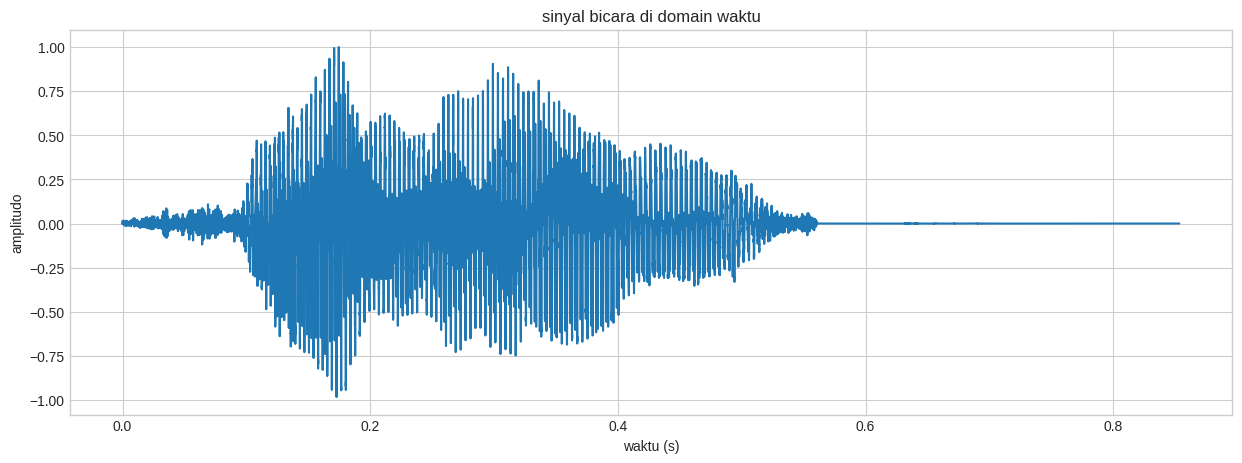

suara asli


In [17]:
if 'audio_signal' in locals():
    
    # visualisasi sinyal waktu
    plt.figure(figsize=(15, 5))
    plt.plot(t, audio_signal)
    plt.title("sinyal bicara di domain waktu")
    plt.xlabel("waktu (s)")
    plt.ylabel("amplitudo")
    plt.show()

    # suara sinyal asli
    print("suara asli")
    display(Audio(data=audio_signal, rate=sample_rate))
else:
    print("sinyal belum dimuat")


**Analisis Domain Waktu**: Plot di atas menggambarkan bentuk gelombang dari suara bicara. Kita bisa melihat bagian mana yang memiliki volume tinggi dan rendah, namun kita tidak bisa mengetahui informasi tentang nada atau frekuensi suara tersebut. Untuk itulah kita memerlukan FFT.

## Penerapan FFT dan Visualisasi Spektrum Frekuensi
Penjelasan Konseptual: **Fast Fourier Transform (FFT)** adalah algoritma yang menguraikan sinyal waktu menjadi komponen-komponen frekuensi penyusunnya. Hasilnya adalah spektrum frekuensi yang menunjukkan seberapa kuat (magnitudo) setiap frekuensi yang ada dalam sinyal.

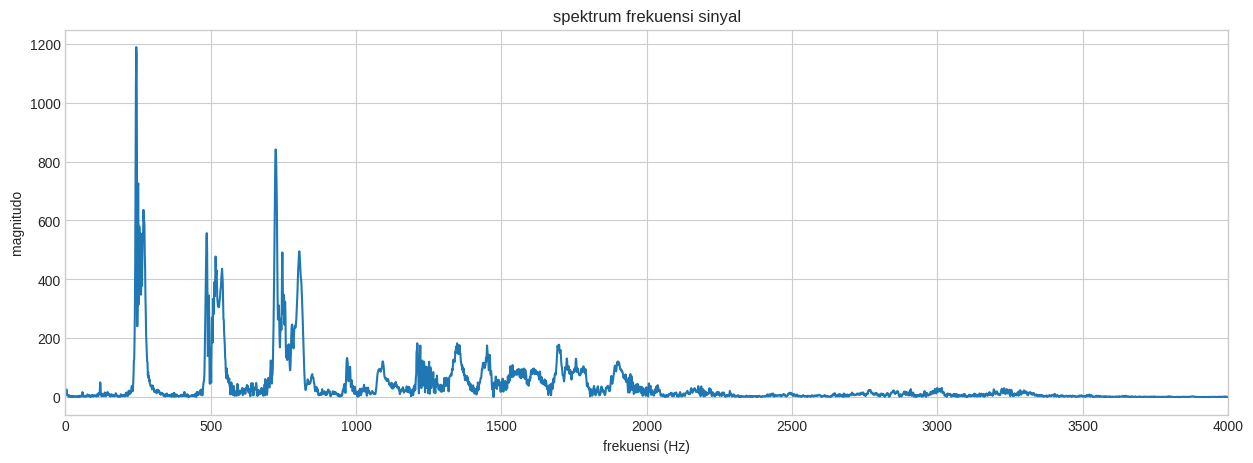

In [18]:
if 'audio_signal' in locals():
    # menghitung FFT
    fft_result = fft(audio_signal)
    magnitude = np.abs(fft_result)

    # membuat sumbu frekuensi
    freq_axis = fftfreq(N, 1/sample_rate)

    # ambil spektrum simetris
    positive_mask =  freq_axis >= 0

    # visualisasi spektrum frekuensi
    plt.figure(figsize=(15, 5))
    plt.plot(freq_axis[positive_mask], magnitude[positive_mask])
    plt.title("spektrum frekuensi sinyal")
    plt.xlabel("frekuensi (Hz)")
    plt.ylabel("magnitudo")
    plt.xlim(0, 4000) #fokus rentang frekuensi manusia
    plt.show()
else:
    print("sinyal belum dimuat")

**Analisis Domain Frekuensi**: Grafik ini adalah "sidik jari" frekuensi dari suara bicara. Puncak-puncak (peaks) pada grafik ini merepresentasikan frekuensi-frekuensi yang paling dominan. Puncak pertama yang signifikan biasanya adalah frekuensi fundamental (F0) atau nada dasar, sedangkan puncak-puncak berikutnya adalah harmoniknya yang membentuk warna suara (timbre).

## Identifikasi Komponen Frekuensi Dominan
*Penjelasan Konseptual*: Dengan menganalisis spektrum frekuensi, kita dapat mengidentifikasi frekuensi fundamental (F0), yang menentukan persepsi "pitch" atau nada dari suara. Kita akan mencari puncak tertinggi pertama dalam rentang frekuensi vokal manusia.

In [19]:
if 'audio_signal' in locals():
    # batasi pencarian di frekuensi vokal manusia
    vocal_range_mask = (freq_axis >= 70) & (freq_axis <= 500)

    # gabungkan dg frekuensi positive
    search_mask = positive_mask & vocal_range_mask

    #cari indek dari magnitudo terbesar di rentang vokal
    if np.any(search_mask):
        dominant_peak_indek = search_mask.nonzero()[0][0] + np.argmax(magnitude[search_mask])

        # mendapatkan nilai frekuensi yang sesuai
        f0 = freq_axis[dominant_peak_indek]
        print(f"Frekuensi fundamental (F0) atau nada dasar dari suara ini diperkirakan berada di sekitar: {f0:.2f} Hz")

        if 70 <= f0 <= 180:
            print("(berada dalam rentang suara dewasa)")
        elif 165 <= f0 <= 255:
            print("(berada dalam rentang wanita dewasa)")
            
    else:
        print("tidak dapat menemukan puncak dominal dalam rentang vokal")
        
else:
    print("sinyal belum dimuat")

Frekuensi fundamental (F0) atau nada dasar dari suara ini diperkirakan berada di sekitar: 243.75 Hz
(berada dalam rentang wanita dewasa)


**Analisis Frekuensi Dominan**: Hasil di atas menunjukkan frekuensi dasar (F0) dari suara yang direkam. Nilai ini secara langsung berkaitan dengan tinggi rendahnya nada suara. Nilai F0 yang rendah mengindikasikan suara yang berat (bass), sedangkan F0 yang tinggi mengindikasikan suara yang melengking (sopran).

## Refleksi dan Kesimpulan
- **Refleksi Pribadi**
  Tantangan dalam pengerjaan tugas ini adalah memahami bagaimana output dari fungsi *fft* dan *fftfreq* saling berhubungan untuk menghasilkan plot spektrum yang benar. Awalnya, plot yang dihasilkan tidak informatif karena rentang frekuensi yang ditampilkan terlalu lebar. Setelah memfokuskan plot pada rentang frekuensi suara manusia (0-4000 Hz), puncak-puncak yang relevan menjadi jauh lebih jelas. Eksperimen ini memberikan intuisi yang kuat tentang bagaimana sinyal yang kita dengar setiap hari dapat diuraikan menjadi komponen matematis yang terukur.
- **Pembelajaran Utama**
  Saya belajar bahwa FFT adalah alat yang sangat fundamental dan kuat untuk "melihat ke dalam" sebuah sinyal dan memahami karakteristiknya yang tidak terlihat di domain waktu. Saya juga memahami konsep frekuensi fundamental (F0) dan bagaimana ia secara langsung berhubungan dengan persepsi kita terhadap nada (pitch).
- **Keimpulan**
  Eksperimen ini telah berhasil mendemonstrasikan alur kerja analisis sinyal bicara menggunakan FFT. Sinyal waktu dari sebuah file audio lokal berhasil dimuat, ditransformasikan ke domain frekuensi, dan divisualisasikan untuk dianalisis. Komponen frekuensi dominan yang berkaitan dengan nada dasar suara juga berhasil diidentifikasi. Proses ini mengonfirmasi bahwa FFT adalah metode yang esensial dan efektif untuk ekstraksi informasi dari sinyal suara.